In [1]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d danielshanbalico/dog-emotion
unzip -qq dog-emotion.zip

100%|██████████| 155M/155M [00:08<00:00, 20.1MB/s]


# Dog Emotion Classification

## Importing required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.preprocessing import image
import pathlib

## Pre-Processing

In [3]:
labels = pd.read_csv("Dog Emotion/labels.csv")
labels.head()

,Unnamed: 0,filename,label
0,0,yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg,sad
1,1,c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg,sad
2,2,RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg,angry
3,3,gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg,angry
4,4,U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg,relaxed


In [4]:

image_files = pathlib.Path("Dog Emotion")
image_data = list(image_files.glob("*/*.jpg"))
image_count = len(image_data)

In [5]:
image_count

3975

In [6]:
le = LabelEncoder()
labels["label"] = le.fit_transform(labels["label"])
le.classes_

array(['angry', 'happy', 'relaxed', 'sad'], dtype=object)

In [7]:
X = labels["filename"]
y = labels["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
str(list(image_data)[0])

'Dog Emotion/angry/la3hd5AcrD0EQHvRUY0a8rQ7NX8k49782.jpg'

In [9]:
str(list(image_files.glob("*/" + X.values[0]))[0])

'Dog Emotion/sad/yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg'

In [10]:
X_train.values[1]

'dpwqgSLwQiVy4GaWt4Yps4YngWZPyj782.jpg'

In [11]:
def preprocess_image(X, y, file_path):
  image_files = pathlib.Path(file_path)
  X = X.values
  y = y.values
  image_label = []
  image_data = []
  for i in range(len(X)):
    image_path = str(list(image_files.glob("*/" + str(X[i])))[0])
    try:
      image = tf.io.read_file(image_path)
      image = tf.image.decode_jpeg(image, channels=3)
      image = tf.image.resize(image, (224, 224))
      image /= 255.0
      image_data.append(image)
      image_label.append(y[i])
    except:
      print("[-] Error preprocessing (ignoring) file : " + image_path)
      pass
  
  return image_data, image_label

In [12]:
X_tf_train, y_tf_train = preprocess_image(X_train, y_train, "Dog Emotion")

[-] Error preprocessing (ignoring) file : Dog Emotion/angry/LUJxTLz9XDGv5gk59SsID20HCxtrhD574.jpeg
[-] Error preprocessing (ignoring) file : Dog Emotion/angry/hcerZKRmlGS9kqqEu0isqfDus7aC4O579.jpg
[-] Error preprocessing (ignoring) file : Dog Emotion/angry/DTpJgFAOWeCDGgcXU1PbXjvfdCvSio578.jpg


In [13]:
X_tf_test, y_tf_test = preprocess_image(X_test, y_test, "Dog Emotion")

In [14]:
len(X_tf_train), len(y_tf_train), len(X_tf_test), len(y_tf_test)

(3197, 3197, 800, 800)

In [15]:
X_tf_train = np.array(X_tf_train)
X_tf_test = np.array(X_tf_test)
y_tf_train = np.array(y_tf_train)
y_tf_test = np.array(y_tf_test)

## Building Model

In [16]:
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [17]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 27,562,308
Trainable params: 12,847,620
Non-tra

## Training model

In [18]:
history = model.fit(X_tf_train, y_tf_train, epochs=10, validation_data=(X_tf_test, y_tf_test))

Epoch 1/10
100/100 [==============================] - 32s 205ms/step - loss: 1.9570 - accuracy: 0.4348 - val_loss: 1.0436 - val_accuracy: 0.5512
Epoch 2/10
100/100 [==============================] - 20s 197ms/step - loss: 0.9979 - accuracy: 0.5802 - val_loss: 1.0023 - val_accuracy: 0.5550
Epoch 3/10
100/100 [==============================] - 20s 202ms/step - loss: 0.8474 - accuracy: 0.6368 - val_loss: 0.9628 - val_accuracy: 0.5738
Epoch 4/10
100/100 [==============================] - 19s 195ms/step - loss: 0.7827 - accuracy: 0.6778 - val_loss: 0.9837 - val_accuracy: 0.5487
Epoch 5/10
100/100 [==============================] - 18s 176ms/step - loss: 0.7424 - accuracy: 0.6894 - val_loss: 0.9815 - val_accuracy: 0.5688
Epoch 6/10
100/100 [==============================] - 18s 179ms/step - loss: 0.6383 - accuracy: 0.7369 - val_loss: 0.9387 - val_accuracy: 0.5950
Epoch 7/10
100/100 [==============================] - 18s 181ms/step - loss: 0.5738 - accuracy: 0.7682 - val_loss: 1.0052 - val_ac

## Making Prediction

In [19]:
import matplotlib.pyplot as plt

def predict_dog_emotion(image_loc):
  test_image = image.load_img(image_loc, target_size=(224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  test_image /= 255.0
  result = model.predict(test_image)
  predicted = np.max(result[0])
  print(predicted)
  predicted = result.tolist()[0].index(predicted)
  plt.imshow(np.uint8(test_image[0] * 255))
  predicted = le.classes_[predicted]
  plt.title(predicted)
  plt.show()

1/1 [==============================] - 1s 837ms/step
0.7843007


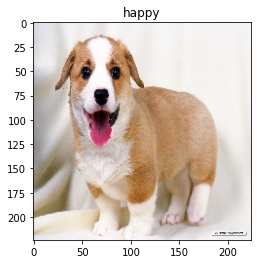

In [20]:
!wget -q http://images4.fanpop.com/image/photos/16700000/Dogs-dogs-16762003-1024-768.jpg
filename_to_pred = "Dogs-dogs-16762003-1024-768.jpg"

predict_dog_emotion(filename_to_pred)

1/1 [==============================] - 0s 23ms/step
0.68507546


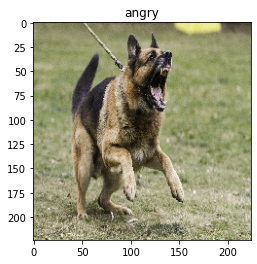

In [22]:
!wget -q https://jooinn.com/images/angry-dog-5.jpg
filename_to_pred = "angry-dog-5.jpg"

predict_dog_emotion(filename_to_pred)